<a href="https://colab.research.google.com/github/JasmineMamdouh/Handwritten_Digit_Recognition/blob/main/MNIST_Detection_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Library Imports

In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input, GlobalAveragePooling2D
from tensorflow.keras import Model
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import numpy as np
import matplotlib.pyplot as plt



#Functions:

In [7]:
def add_random_noise(x, noise_factor=0.2):
    # Randomly generate noise
    noise = np.random.randn(*x.shape) * noise_factor

    # Add noise to the input data (x)
    x_noisy = x + noise

    # Clip the values to ensure they are within the valid range (0 to 1)
    x_noisy = np.clip(x_noisy, 0., 1.)

    return x_noisy


In [8]:
def generate_bounding_box(img):
    #set a threshold value to ensure that the pixel values correspond to white or near-white region
    threshold = 0.6

    # Ensure image has content (is not entirely black) since the background is black and the digits are white or near white (with pixel values closer to 1
    rows = np.any(img > threshold, axis=1)
    cols = np.any(img > threshold, axis=0)

    #handle the case if image is is completely black or below the threshold
    if not np.any(rows) or not np.any(cols):
        # Return a empty bounding box for empty images
        return [0, 0, 0, 0]


    # Find bounding box for non-empty images
    ymin, ymax = np.where(rows)[0][[0, -1]]
    xmin, xmax = np.where(cols)[0][[0, -1]]

    #Noramalize the corrdinates
    ymin , ymax = ymin / 28.0, ymax / 28.0
    xmin, xmax = xmin / 28.0, xmax / 28.0

    width = xmax - xmin
    height = ymax - ymin


    return [xmin, ymin, width, height]

preprocess function with the noise being added

In [9]:
def preprocess_mnist(add_noise=False):
    # Load the MNIST dataset
    mnist = tf.keras.datasets.mnist
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    # Normalize and reshape images
    x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0
    x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0

    # Add random noise if needed
    if add_noise:
        x_train = add_random_noise(x_train)
        x_test = add_random_noise(x_test)

    # Convert y labels to categorical (one-hot encoding)
    y_train = to_categorical(y_train, num_classes=10)
    y_test = to_categorical(y_test, num_classes=10)

    # Generate synthetic bounding box coordinates
    y_train_box = np.array([generate_bounding_box(img.squeeze()) for img in x_train])
    y_test_box = np.array([generate_bounding_box(img.squeeze()) for img in x_test])

    return (x_train, y_train, y_train_box), (x_test, y_test, y_test_box)

In [10]:
from tensorflow.keras.layers import Dropout
#adding dropout layers to prevent overfitting and improve generalization
def create_model():
    input_layer = Input(shape=(28, 28, 1))

    # Shared convolutional base
    c = Conv2D(32, (3, 3), activation='relu')(input_layer)
    c = MaxPooling2D((2, 2))(c)
    c = Dropout(0.25)(c)  # Add dropout
    c = Conv2D(64, (3, 3), activation='relu')(c)
    c = MaxPooling2D((2, 2))(c)
    c = Dropout(0.25)(c)  # Add dropout
    c = Conv2D(128, (3, 3), activation='relu')(c)
    c = GlobalAveragePooling2D()(c)

    # Classification output
    classification_output = Dense(10, activation='softmax', name='classification')(c)

    # Localization output
    localization_output = Dense(4, name='localization')(c)

    # Define the model
    model = Model(inputs=input_layer, outputs=[classification_output, localization_output])

    # Configures the model with the optimizer, loss functions, and metrics it will use during training.
    model.compile(optimizer='adam',
                  loss={'classification': 'categorical_crossentropy',
                        'localization': 'mean_squared_error'},
                  metrics={'classification': 'accuracy'})

    return model


In [11]:
def predict_and_display(model , x, y_true, y_true_box, n_samples = 5):
  y_pred, y_pred_box = model.predict(x)

  # Calculate overall test accuracy
  y_pred_labels = np.argmax(y_pred, axis=1)
  y_true_labels = np.argmax(y_true, axis=1)
  accuracy = accuracy_score(y_true_labels, y_pred_labels)

  # Print overall accuracy
  print(f'Overall Test Accuracy: {accuracy:.4f}')

  for i in range(n_samples):

    #Extract True and Predicted Labels
    true_label = np.argmax(y_true[i])
    pred_label = np.argmax(y_pred[i])

    #Extract True and Predicted Bounding Boxes
    true_box = y_true_box[i]
    pred_box = y_pred_box[i]

    fig, pt = plt.subplots(1)
    pt.imshow(x[i].reshape(28, 28), cmap = 'gray')

    #Draw True bounding box in green
    rect_true = plt.Rectangle((true_box[0] * 28, true_box[1] * 28), true_box[2] * 28, true_box[3] * 28, linewidth = 2, edgecolor = 'green', facecolor='none')
    pt.add_patch(rect_true)

    #Draw Predicted bounding box in red
    rect_pred = plt.Rectangle((pred_box[0] * 28, pred_box[1] * 28), pred_box[2] * 28, pred_box[3] * 28, linewidth = 2, edgecolor = 'red', facecolor='none')
    pt.add_patch(rect_pred)


    pt.set_title(f'True: {true_label}, Pred: {pred_label}')
    plt.show()




#Build & Train the model

## original data

Use the preprocess function

In [12]:
(x_train,y_train, y_train_box), (x_test,y_test, y_test_box) = preprocess_mnist(add_noise = False)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
model_original = create_model()

# Split the training data into training and validation sets
x_train, x_val, y_train, y_val, y_train_box, y_val_box = train_test_split(
    x_train, y_train, y_train_box, test_size=0.2, random_state=42
)

# Train the model with the validation set
history_original = model_original.fit(
    x_train,
    {'classification': y_train, 'localization': y_train_box},
    epochs=10,
    batch_size=32,
    validation_data=(x_val, {'classification': y_val, 'localization': y_val_box})
)


Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - classification_accuracy: 0.7520 - loss: 0.7810 - val_classification_accuracy: 0.9543 - val_loss: 0.1626
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - classification_accuracy: 0.9610 - loss: 0.1364 - val_classification_accuracy: 0.9766 - val_loss: 0.0790
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - classification_accuracy: 0.9730 - loss: 0.0918 - val_classification_accuracy: 0.9835 - val_loss: 0.0615
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - classification_accuracy: 0.9803 - loss: 0.0672 - val_classification_accuracy: 0.9857 - val_loss: 0.0511
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - classification_accuracy: 0.9840 - loss: 0.0545 - val_classification_accuracy: 0.9862 - val_loss: 0.0481
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - classification_accuracy: 0.9857 - loss: 0.0483 - val_classification_accuracy: 0.9875 - val_loss: 0.0436
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Overall Test Accuracy: 0.9908


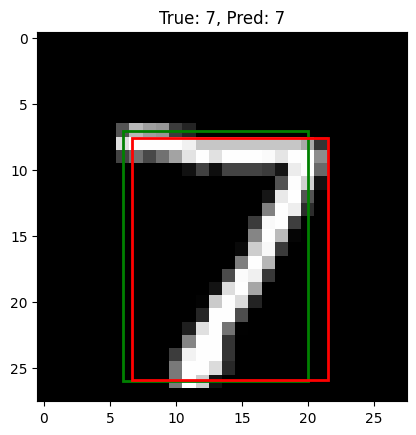

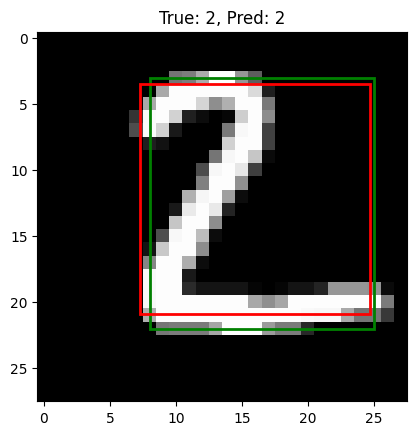

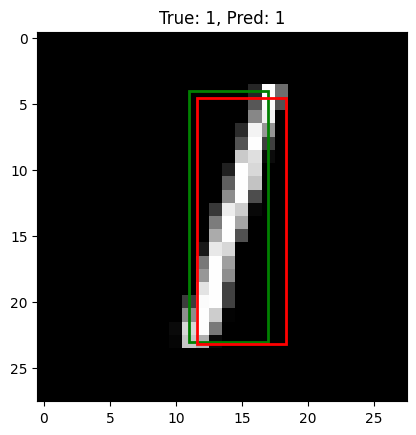

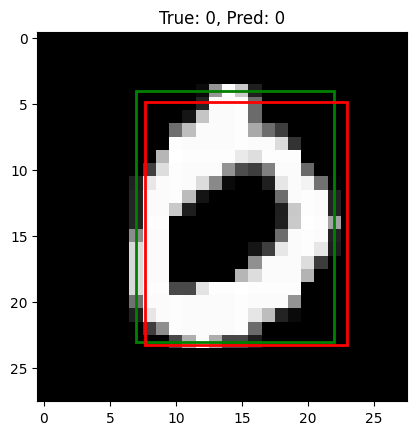

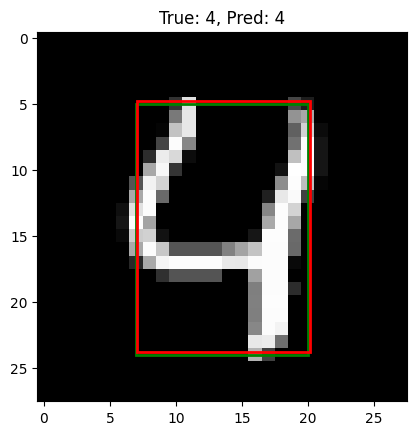

In [14]:
#test the model
predict_and_display(model_original, x_test,y_test, y_test_box)

In [15]:
print(x_train.shape)
print(y_train.shape)
print(y_train_box.shape)
print(x_test.shape)
print(y_test.shape)
print(y_test_box.shape)

(48000, 28, 28, 1)
(48000, 10)
(48000, 4)
(10000, 28, 28, 1)
(10000, 10)
(10000, 4)


In [16]:
##check for the data balance
# Assuming y_test is the one-hot encoded test labels
y_true_labels = np.argmax(y_train, axis=1)  # Convert to class labels

# Count occurrences of each digit
unique, counts = np.unique(y_true_labels, return_counts=True)
digit_counts = dict(zip(unique, counts))

# Print the counts
print(digit_counts)

{0: 4748, 1: 5420, 2: 4784, 3: 4912, 4: 4666, 5: 4317, 6: 4741, 7: 4966, 8: 4691, 9: 4755}


##noisy data

In [17]:
(x_train_noisy, y_train_noisy, y_train_box_noisy), (x_test_noisy,y_test_noisy, y_test_box_noisy) = preprocess_mnist(add_noise=True)

model_noisy = create_model()

# Split the training data into training and validation sets
x_train_noisy, x_val_noisy, y_train_noisy, y_val_noisy, y_train_box_noisy, y_val_box_noisy = train_test_split(
    x_train_noisy, y_train_noisy, y_train_box_noisy, test_size=0.2, random_state=42
)

# Train the model with the validation set
history_noisy = model_noisy.fit(
    x_train_noisy,
    {'classification': y_train_noisy, 'localization': y_train_box_noisy},
    epochs=10,
    batch_size=32,
    validation_data=(x_val_noisy, {'classification': y_val_noisy, 'localization': y_val_box_noisy})
)


Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - classification_accuracy: 0.6928 - loss: 0.9309 - val_classification_accuracy: 0.9551 - val_loss: 0.1616
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - classification_accuracy: 0.9546 - loss: 0.1665 - val_classification_accuracy: 0.9696 - val_loss: 0.1227
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - classification_accuracy: 0.9660 - loss: 0.1196 - val_classification_accuracy: 0.9749 - val_loss: 0.0946
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - classification_accuracy: 0.9752 - loss: 0.0910 - val_classification_accuracy: 0.9843 - val_loss: 0.0622
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - classification_accuracy: 0.9794 - loss: 0.0755 - val_classification_accuracy: 0.9852 - val_loss: 0.0601
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - classification_accuracy: 0.9813 - loss: 0.0663 - val_classification_accuracy: 0.9876 - val_loss: 0.0494
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Overall Test Accuracy: 0.9891


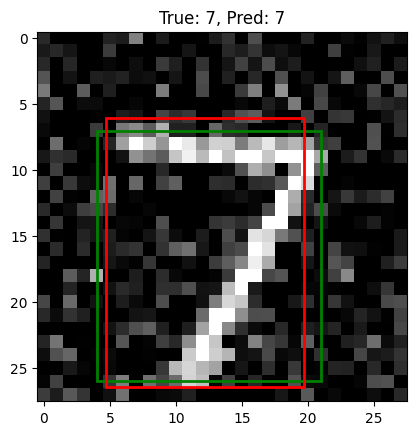

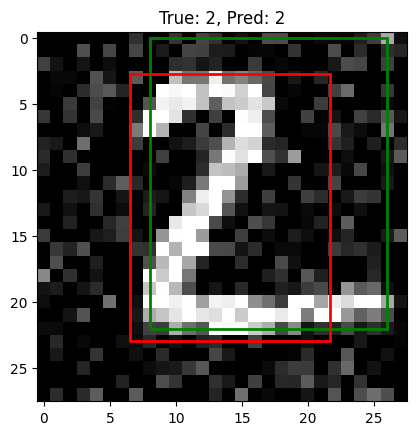

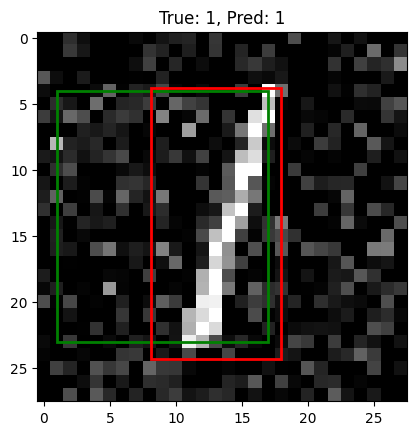

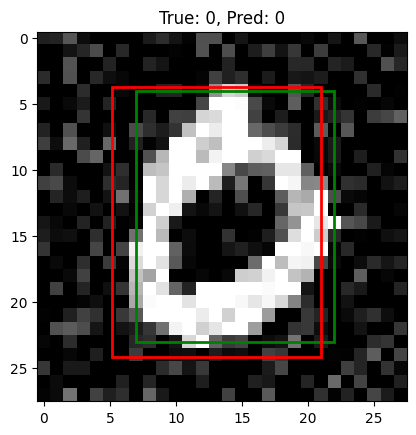

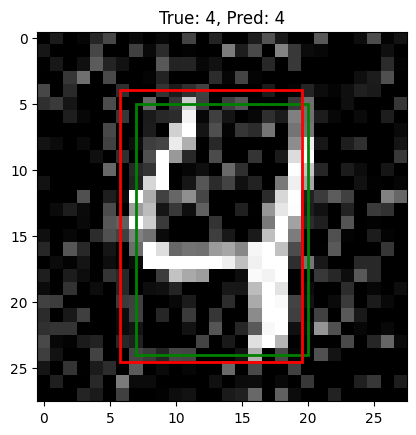

In [18]:
#test the model
predict_and_display(model_noisy, x_test_noisy,y_test, y_test_box_noisy)

##Comparison

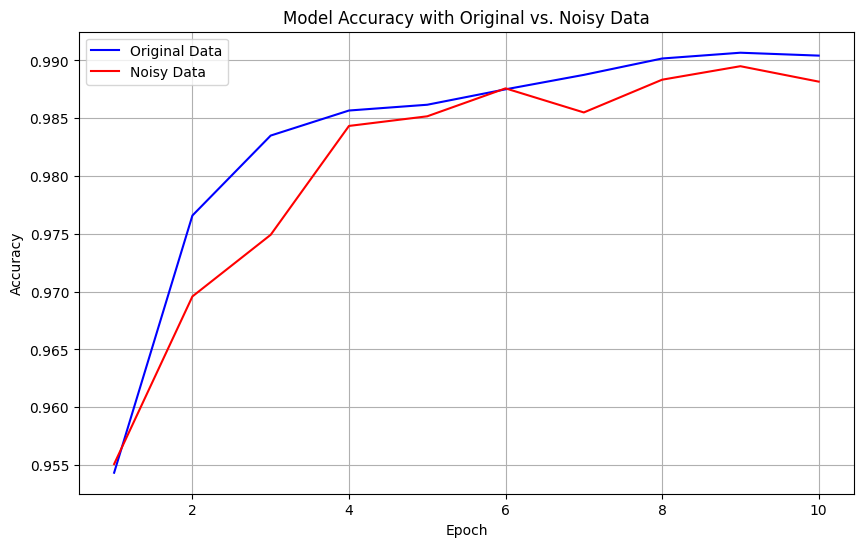

In [19]:
epochs = range(1, 11)
plt.figure(figsize=(10, 6))
plt.plot(epochs, history_original.history['val_classification_accuracy'], 'b-', label='Original Data')
plt.plot(epochs, history_noisy.history['val_classification_accuracy'], 'r-', label='Noisy Data')
plt.title('Model Accuracy with Original vs. Noisy Data')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


#Save and Download the model

In [20]:
model_original.save('/content/MNIST_modell.h5')

In [21]:
#from google.colab import files
#files.download('/content/MNIST_modell.h5')

#Test using external images

In [22]:
from PIL import Image, ImageEnhance
import cv2

In [23]:
def preprocess_image(image_path):
    # Load the image and convert it to grayscale ('L' mode)
    img = Image.open(image_path).convert('L')

    # Resize to 28x28
    img = img.resize((28, 28))

    # Enhance contrast to make the digit more prominent
    enhancer = ImageEnhance.Contrast(img)
    img = enhancer.enhance(2.0)  # You can adjust the contrast factor

    # Convert the image to a NumPy array and normalize pixel values
    img_array = np.array(img).astype('float32') / 255.0

    # Check if the image has non-uniform background and normalize it
    img_array = img_array - img_array.min()  # Ensure background is near zero
    img_array = img_array / img_array.max()  # Normalize to [0, 1] range

    # Reshape to match model input shape
    img_array = img_array.reshape(1, 28, 28, 1)

    return img_array


In [24]:
def predict_image(model, image_path):
    # Preprocess the single image
    img_array = preprocess_image(image_path)
    # Predict for the single image
    classification, localization = model.predict(img_array)

    # Display results
    plt.figure()
    plt.imshow(img_array.reshape(28, 28), cmap='gray')

    # Predicted bounding box in red
    #localization[0] accesses the bounding box coordinates for that first (and only) image in the batch
    pred_box = localization[0]
    rect_pred = plt.Rectangle((pred_box[0] * 28, pred_box[1] * 28), pred_box[2] * 28, pred_box[3] * 28, linewidth=2, edgecolor='red', facecolor='none')
    plt.gca().add_patch(rect_pred)

    #classification[0] accesses the predicted probabilities for the first (and only) image in the batch.
    pred_label = np.argmax(classification[0])
    plt.title(f'Predicted Label: {pred_label}')
    plt.show()

In [25]:
from google.colab import files
uploaded = files.upload()

Saving Screenshot 2024-09-11 210049.png to Screenshot 2024-09-11 210049 (1).png
Saving Screenshot 2024-09-11 214808.png to Screenshot 2024-09-11 214808 (1).png
Saving Screenshot 2024-09-11 231735.png to Screenshot 2024-09-11 231735 (1).png
Saving Screenshot 2024-09-11 231747.png to Screenshot 2024-09-11 231747 (1).png
Saving Screenshot 2024-09-11 231757.png to Screenshot 2024-09-11 231757 (1).png
Saving Screenshot 2024-09-11 231929.png to Screenshot 2024-09-11 231929 (1).png
Saving Screenshot 2024-09-11 231948.png to Screenshot 2024-09-11 231948 (1).png
Saving Screenshot 2024-09-11 232349.png to Screenshot 2024-09-11 232349 (1).png
Saving Screenshot 2024-09-11 232720.png to Screenshot 2024-09-11 232720 (1).png
Saving Screenshot 2024-09-11 233117.png to Screenshot 2024-09-11 233117 (1).png


Uploaded image: Screenshot 2024-09-11 210049 (1).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


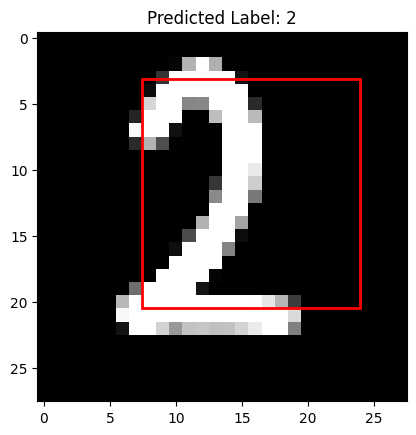

Uploaded image: Screenshot 2024-09-11 214808 (1).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


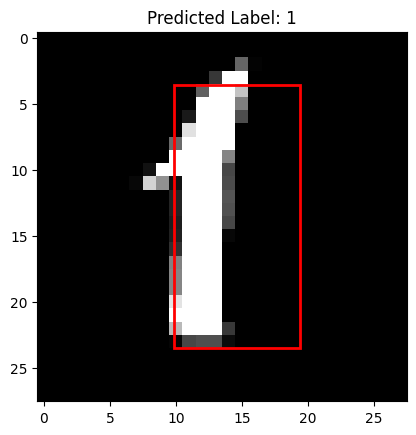

Uploaded image: Screenshot 2024-09-11 231735 (1).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


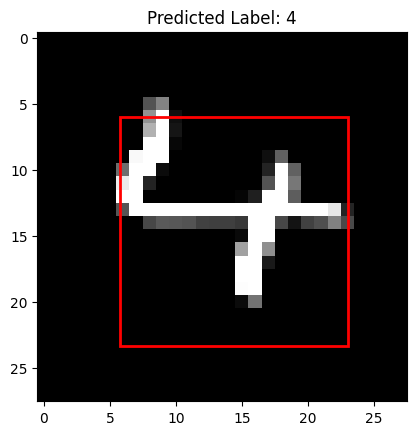

Uploaded image: Screenshot 2024-09-11 231747 (1).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


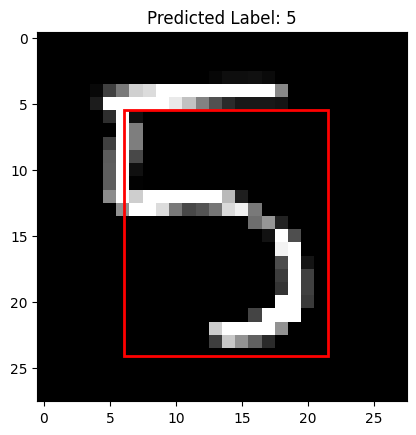

Uploaded image: Screenshot 2024-09-11 231757 (1).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


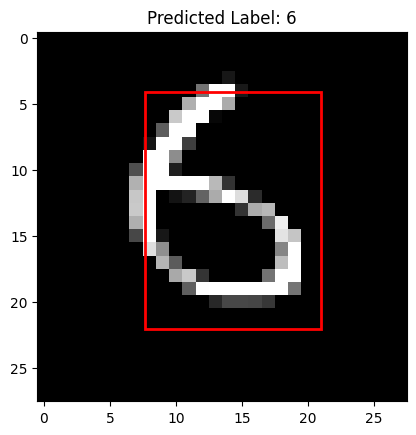

Uploaded image: Screenshot 2024-09-11 231929 (1).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


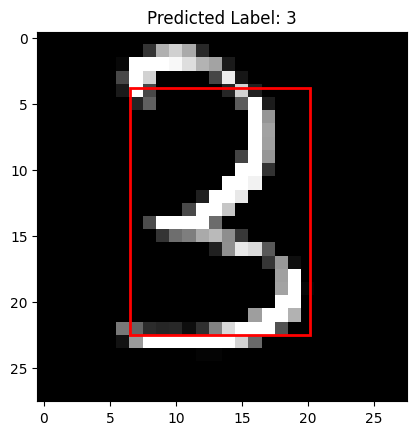

Uploaded image: Screenshot 2024-09-11 231948 (1).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


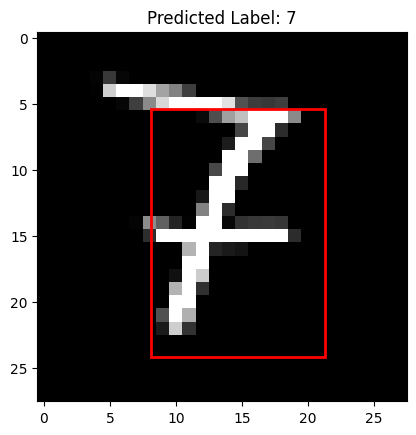

Uploaded image: Screenshot 2024-09-11 232349 (1).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


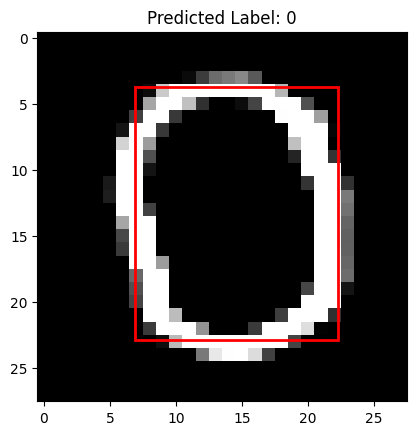

Uploaded image: Screenshot 2024-09-11 232720 (1).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


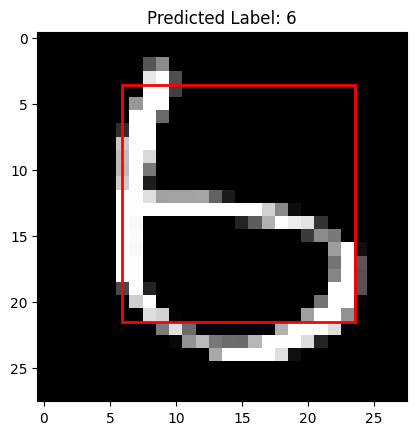

Uploaded image: Screenshot 2024-09-11 233117 (1).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


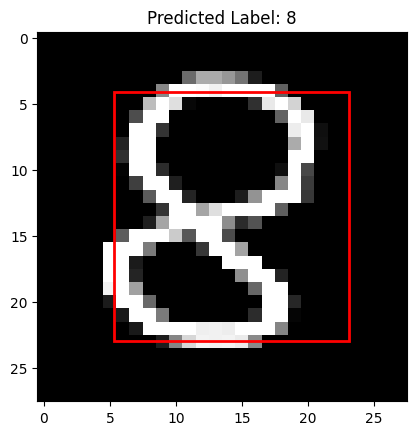

In [26]:
# Make predictions on uploaded images
for image_name in uploaded.keys():
    print(f'Uploaded image: {image_name}')
    predict_image(model_original, image_name)